In [1]:
# Here are some attempts on figuring out a way to partition space.
# First a description of what I think should be the (ideal) goal.
# Ideally we want a datastructure that is both reusable and fast.
# Combining the two isn't easy, but there is a world where a KD-tree
# can be useful in this.
#
# One thing that is theoretically possible with KD-trees, is simple translation.
# See also in the figures below. A framework as shown there can be simply translated in space,
# together with the average movement of the particles of the system.
# One could also imagine that a more complicated transformation is possible. Imagine the
# first dividing line (in the middle), you could move the line and rescale all boundaries
# if for example particles on the left are "pushing" on particles on the right.
# This can be done even at lower levels, of course at the cost of complexity.
# I haven't actually tried this out. It will depend on the simulations themselves,
# whether the idea is actually of any use. If the biggest component of the 
# movement of particles is shared by the average movement, then this might work well.
#
# I have struggled a lot with the KD-trees and trying to find some kind of optimal solution
# to putting the boundary between particles. In my view, for the optimal solution there
# are two competing costs or terms:
# The cost of having an imbalanced tree, and the cost of having an imbalanced space partition.
# Ideally we want to have both optimal, but I haven't figured out how to do it properly.
# The third algorithm shown here attempts to do this balancing act, however it doesn't work at
# the moment. The second algorithm balances the distances between particles on the left and right
# side. Indirectly it probably balances the two costs, but it's hard to know when there's not yet
# a proper benchmark.
#
# Another idea is to use a hash-based datastructure instead of the KD-tree. I think Christian calls
# these octo-trees. One advantage of this method is that the implementation is more obvious.
# One would start by defining a minimum size box. One idea for this minimum size would be to set it to the maximum
# interaction distance. The advantage of this is that you can guarentee that only neighboring boxes have to be
# considered. Thus finding all close neighbors should be pretty fast. There is an argument to be made not to
# create all layers of the tree, but only the lowest level. The advantage is that creating the "tree"
# is then only linear in the number of particles? The disadvantage is of course that it necessitates
# a clever and efficient hashing algorithm, and it is not necessarily the most memory efficient
# (depending on the hashing).

# One difficulty that I haven't incorporated yet is the fact that we're dealing with non-cartesian coordinates.
# I don't think it makes that unsolvable, but it will require some additional thought.

import xarray as xr
import numpy as np
import warnings
from matplotlib import pyplot as plt
from copy import deepcopy

In [2]:
# Unused for the moment
#particle_data = xr.open_dataset("Peninsula.nc")
#particle_data.lat[1002]

In [3]:
# Simple KD-Tree as given on wikipedia, except that it splits between the two median values,
# instead of on it exactly.
# Split on the median value of the current dimension.
# Cycles through dimensions 0, 1, 2, ..., 0, 1, 2, ...
# At each node a tuple is given: (split_value, tree_left, tree_right).
# At each leaf the following tuple is given: (sorted_indices, sorted_values), where the indices and values are 
# for each of the points belonging to the leaf. In this implementation, there is only one point at each leave.
# Max_dist is unused.

def build_kd_tree(values, cur_dim=0, subset=None, max_dist=0.1):
    if subset is None:
        subset = np.arange(values.shape[1])
    # Assume subset is already sorted correctly.

    sorted_order = np.argsort(values[cur_dim, subset])
    sorted_subset = subset[sorted_order]
    sorted_values = values[cur_dim, sorted_subset]
    if len(subset) <= 1: #or sorted_values[-1] - sorted_values[0] < max_dist:
        return sorted_subset, sorted_values
    
    median_i = int(len(subset)/2)
    median_val = (sorted_values[median_i]+sorted_values[median_i-1])/2
    new_dim = (cur_dim+1)%values.shape[0]
    assert len(sorted_subset[:median_i]) + len(sorted_subset[median_i:]) == len(subset)
    return (median_val,
            build_kd_tree(values, new_dim, subset=sorted_subset[:median_i], max_dist=max_dist),
            build_kd_tree(values, new_dim, subset=sorted_subset[median_i:], max_dist=max_dist))




In [4]:
def build_kd_tree_2(values, cur_dim=0, subset=None, max_dist=0.1):
    # The tree that is created here has the same structure as the one above.
    # The difference is in the selection of the midpoint.
    # It minimizes the difference between all distances (squared?) between the points on the
    # left and right side. Otherwise it follows a similar procedure as the algorithm above.
    if subset is None:
        subset = np.arange(values.shape[1])


    sorted_order = np.argsort(values[cur_dim, subset])
    sorted_subset = subset[sorted_order]
    sorted_values = values[cur_dim, sorted_subset]

    if len(subset) <= 1:
        return sorted_subset, sorted_values

    sq_vals = values[:, sorted_subset]**2
    cum_sq = len(subset)*np.sum(np.cumsum(sq_vals, axis=1), axis=0)
    cum_mean = np.cumsum(values[:, sorted_subset], axis=1)
    left_distance = cum_sq - len(subset)**1*np.sum((cum_mean/np.arange(1, len(subset)+1))**2, axis=0)
    reverse_mean = (cum_mean[:, [-1]] - cum_mean)/np.arange(len(subset), 0, -1)
    reverse_sq_mean = (cum_sq[-1] - cum_sq)
    right_distance = reverse_sq_mean - np.sum(reverse_mean**2, axis=0)

    median_i = int(len(subset)/2)
    #print(median_i, np.argmin(np.abs(left_distance[:-1]-right_distance[1:])))
    median_i = np.argmin(np.abs(left_distance[:-1]-right_distance[1:]))+1
    median_val = (sorted_values[median_i]+sorted_values[median_i-1])/2
    new_dim = (cur_dim+1)%values.shape[0]
    assert len(sorted_subset[:median_i]) + len(sorted_subset[median_i:]) == len(subset)
    return (median_val,
            build_kd_tree_2(values, new_dim, subset=sorted_subset[:median_i], max_dist=max_dist),
            build_kd_tree_2(values, new_dim, subset=sorted_subset[median_i:], max_dist=max_dist))


In [5]:
def build_kd_tree_3(values, cur_dim=0, subset=None, box=None, max_dist=0.1):
    # This is just a mess that doesn't work. (It will crash the Python stack, so probably doesn't terminate.)
    if subset is None:
        subset = np.arange(values.shape[1])

    sorted_order = np.argsort(values[cur_dim, subset])
    sorted_subset = subset[sorted_order]
    sorted_values = values[cur_dim, sorted_subset]

    if len(subset) <= 1:
        return sorted_subset, sorted_values

    box_start = box[cur_dim][0]
    box_end = box[cur_dim][1]
    N = len(sorted_subset)
    q_i = (1+np.arange(N+2))/(N+1 - np.arange(N+2))
    v_i = np.concatenate(([box_start], sorted_values, [box_end]))
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')
        f_i = 1/(1+q_i[:-1]*(v_i[1:]-box_start)/(box_end - v_i[:-1]))
    f_i[np.isnan(f_i)] = 0.5
    mid_points = f_i*v_i[:-1]+(1-f_i)*v_i[1:]
    #log_decay = np.maximum(np.log(1+))
    #n_lines_left = np.log(1+np.arange(N+1))/np.log()
    #n_lines_right = np.log2(N+1 - np.arange(N+1))
    d_left = mid_points - box_start
    d_right = box_end - mid_points
    d_other = box[cur_dim^1][1] - box[cur_dim^1][0]
    
    #d_other = box[(1-cur_dim)][1] - box[(1-cur_dim)][0]
    #expected_left_ll = n_lines_left*(d_left+d_other)/2
    #expected_right_ll = n_lines_right*(d_right+d_other)/2
    n_left = 0.5+np.arange(N+1)
    n_right = N+0.5 - np.arange(N+1)

    d_fac_left = n_left*np.maximum(1, np.log(d_left/max_dist))*(d_left+d_other)/2
    d_fac_right = n_right*np.maximum(1, np.log(d_right/max_dist))*(d_right+d_other)/2
    n_fac_left = n_left*np.maximum(1, np.log(n_left))*(d_left+d_other)/2
    n_fac_right = n_right*np.maximum(1, np.log(n_right))*(d_right+d_other)/2
    alpha = 0.5
    fac_left = (d_fac_left**alpha + n_fac_left**alpha)**(1/alpha)
    fac_right = (d_fac_right**alpha + n_fac_right**alpha)**(1/alpha)
    
    #plt.plot(fac_left)
    #plt.plot(fac_right)
    #plt.plot(fac_left+fac_right)
    #plt.show()

    #depth_fac = np.maximum(np.log(N)/np.log(N/n_left), np.log(N)/np.log(N/n_right))
    #n_fac = n_left*np.log(n_left/d_left) + n_right*np.log(n_right/d_right)
    #log_like = n_left*np.log(n_left/d_left) + n_right*np.log(n_right/d_right) - depth_fac              
    #plt.plot(n_right)
    #plt.plot(n_left)
    #plt.show()
    #plt.plot(depth_fac)
    #plt.plot(n_fac)
    #plt.show()
    #print(f_i)
    #box_x = box[cur_dim][1] - box[cur_dim][0]
    #min_b = v_i[:-1] - q_i[:-1]*v_i[1:] - q_i[:-1]*box_x
    #denominator = min_b + np.sqrt(min_b*min_b - 4*((1-q_i[:-1])*box_x*v_i[1:]*q_i[:-1]))
    #denom_minus = min_b - np.sqrt(min_b*min_b - 4*((1-q_i[:-1])*box_x*v_i[1:]*q_i[:-1]))
    #d_1 = denominator/(1-q_i[:-1])
    #d_1_minus = denom_minus/(1-q_i[:-1])
    #d_2 = box_x - d_1
    #f = (d_1-v_i[:-1])/(v_i[1:]-v_i[:-1])
    #print(f)
    #plt.plot(v_i)
    #plt.plot()
    #plt.plot(f_i)
    #plt.show()
    #assert False
    #density = np.arange(1, len(sorted_subset)+1)/(sorted_values - box_start)
    
    #sq_vals = values[:, sorted_subset]**2
    #cum_sq = len(subset)*np.sum(np.cumsum(sq_vals, axis=1), axis=0)
    #cum_mean = np.cumsum(values[:, sorted_subset], axis=1)
    #left_distance = cum_sq - len(subset)**1*np.sum((cum_mean/np.arange(1, len(subset)+1))**2, axis=0)
    #reverse_mean = (cum_mean[:, [-1]] - cum_mean)/np.arange(len(subset), 0, -1)
    #reverse_sq_mean = (cum_sq[-1] - cum_sq)
    #right_distance = reverse_sq_mean - np.sum(reverse_mean**2, axis=0)

    #median_i = int(len(subset)/2)
    #print(median_i, np.argmin(np.abs(left_distance[:-1]-right_distance[1:])))
    median_i = np.argmin(np.abs(fac_left+fac_right))+1
    #median_val = (sorted_values[median_i]+sorted_values[median_i-1])/2
    median_val = mid_points[median_i]
    new_dim = (cur_dim+1)%values.shape[0]
    new_box_1 = deepcopy(box)
    new_box_2 = deepcopy(box)
    new_box_1[cur_dim][1] = median_val
    new_box_2[cur_dim][0] = median_val
    if median_i > 0:
        new_tree_1 = build_kd_tree_3(values, new_dim, subset=sorted_subset[:median_i], max_dist=max_dist, box=new_box_1)
    else:
        new_tree_1 = ([], [])
    if median_i < N:
        new_tree_2 = build_kd_tree_3(values, new_dim, subset=sorted_subset[median_i:], max_dist=max_dist, box=new_box_2)
    else:
        new_tree_2 = ([], [])
    assert len(sorted_subset[:median_i]) + len(sorted_subset[median_i:]) == len(subset)
    #return (median_val,
     #       build_kd_tree_3(values, new_dim, subset=sorted_subset[:median_i], max_dist=max_dist, box=new_box_1),
       #     build_kd_tree_3(values, new_dim, subset=sorted_subset[median_i:], max_dist=max_dist, box=new_box_2))
    return (median_val, new_tree_1, new_tree_2)


In [6]:
# Get some random points in 2D.

n_values = 200
np.random.seed(1298037)
values = np.random.randn(200).reshape(2, -1)
values = np.concatenate((values, (2+np.random.randn(100)).reshape(2, -1)), axis=1)
values[1, :] *= 2
box = [[values[i, :].min(), values[i, :].max()] for i in range(values.shape[0])]
values.shape

(2, 150)

In [7]:
# Build the trees

tree_1 = build_kd_tree(values, max_dist=0.2)
tree_2 = build_kd_tree_2(values, max_dist=0.2)
#tree_3 = build_kd_tree_3(values, max_dist=0.2, box=box)

In [8]:
# Function for visualizing KD-trees.
# It draws lines were the separations are.
# The score is simply the length of all the lines drawn.
# A lower score means a better partitioning (assuming all particles are in their own box).

def plot_kd_tree(tree, box):
    #plt.plot(box[0], (box[1][0], box[1][0]))
    def add_lines_point(subtree, cur_box, dim=0):
        if len(subtree) == 2:
            return 0
        median_val = subtree[0]
        if (dim%2) == 0:
            new_box_1 = [[cur_box[0][0], median_val], [*cur_box[1]]]
            new_box_2 = [[median_val, cur_box[0][1]], [*cur_box[1]]]
            plt.plot([median_val, median_val], cur_box[1])
            line_len = cur_box[1][1] - cur_box[1][0]
        else:
            new_box_1 = [[*cur_box[0]], [cur_box[1][0], median_val]]
            new_box_2 = [[*cur_box[0]], [median_val, cur_box[1][1]]]
            plt.plot(cur_box[0], [median_val, median_val])
            line_len = cur_box[0][1] - cur_box[0][0]

        line_len += add_lines_point(subtree[1], new_box_1, dim=dim+1)
        line_len += add_lines_point(subtree[2], new_box_2, dim=dim+1)
        return line_len

    score = add_lines_point(tree, box)
                            
    plt.scatter(values[0], values[1])
    plt.title(f"Score = {score}")
    plt.show()

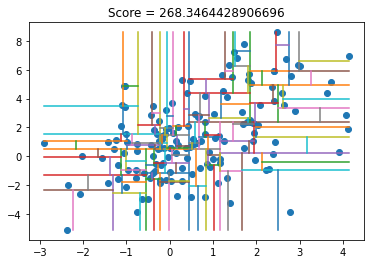

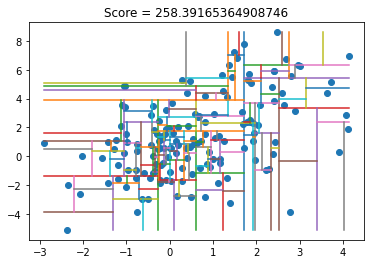

In [9]:
plot_kd_tree(tree_1, box)
plot_kd_tree(tree_2, box)

In [10]:
def count_leaves(tree):
    if len(tree) == 2:
        return len(tree[0])
    return count_leaves(tree[1]) + count_leaves(tree[2])

In [11]:
#count_leaves(tree)

In [12]:
# Try a normal octo tree...
from math import ceil

def hash_split(hash_ids):
    sort_idx = np.argsort(hash_ids)
    a_sorted = hash_ids[sort_idx]
    unq_first = np.concatenate(([True], a_sorted[1:] != a_sorted[:-1]))
    unq_items = a_sorted[unq_first]
    unq_count = np.diff(np.nonzero(unq_first)[0])
    unq_idx = np.split(sort_idx, np.cumsum(unq_count))
    return dict(zip(unq_items, unq_idx))


def hash_to_neighbors(hash_id, bits):
    coor = np.zeros(len(bits), dtype=int)
    new_coor = np.zeros(len(bits), dtype=int)
    tot_bits = 0
    for dim in range(len(bits)):
        coor[dim] = (hash_id >> tot_bits)&((1<<bits[dim])-1)
        tot_bits += bits[dim]

    coor_max = np.left_shift(1, np.array(bits, dtype=int))

    neighbors = []
        
    for offset in range(pow(3, len(bits))):
        divider = 1
        for dim in range(len(bits)):
            new_coor[dim] = coor[dim] + (1-((offset//divider)%3))
            divider *= 3
        if np.any(new_coor > coor_max) or np.any(new_coor < 0):
            continue
        new_hash = 0
        tot_bits = 0
        for dim in range(len(bits)):
            new_hash |= (new_coor[dim]<<tot_bits)
            tot_bits += bits[dim]
        neighbors.append(new_hash)
    return neighbors


def build_octo_tree(values, box, min_dist=0.5):
    bits = []
    min_box = []
    for interval in box:
        epsilon = 1e-8
        n_bits = np.log((interval[1] - interval[0])/min_dist+epsilon)/np.log(2)
        bits.append(ceil(n_bits))
        min_box.append(interval[0])

    min_box = np.array(min_box).reshape(-1, 1)
    box_i = ((values-min_box)/min_dist).astype(int)
    point_hash = np.bitwise_or(box_i[0, :], np.left_shift(box_i[1, :], bits[0]))
    return hash_split(point_hash), point_hash, bits
    #print(box_i)
    #for h in hash[:]:
        #if len(hash_to_neighbors(h, bits)) != 9:
            #print(h, len(hash_to_neighbors(h, bits)))

def find_neighbors(i_val, octo_dict, point_hashes, bits, values, max_dist=0.5):
    hash_id = point_hashes[i_val]
    neighbor_blocks = hash_to_neighbors(hash_id, bits)
    all_neighbor_points = []
    for block in neighbor_blocks:
        try:
            all_neighbor_points.extend(octo_dict[block])
        except KeyError:
            pass

    true_neigh = []
    for neigh in all_neighbor_points:
        if np.linalg.norm(values[:, neigh]-values[:, i_val]) < max_dist:
            true_neigh.append(neigh)
    return true_neigh, len(all_neighbor_points)


def bruteforce_neighbors(i_val, values, max_dist=0.5):
    idx = np.where(np.linalg.norm(values - values[:, i_val:i_val+1], axis=0) < max_dist)[0]
    return idx, values.shape[1]

octo_dict, point_hashes, bits = build_octo_tree(values, box)
print(find_neighbors(0, octo_dict, point_hashes, bits, values))
print(bruteforce_neighbors(0, values))

([91, 0, 79, 43], 8)
(array([ 0, 43, 79, 91]), 150)


In [13]:
# In this section, we adapt previous ideas to non-cartesian coordinates.
# What we'll try first is simply spherical coordinates.

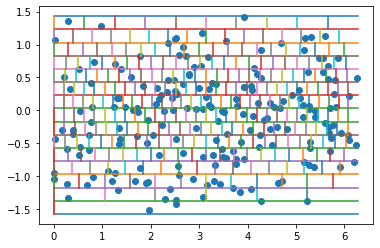

In [14]:
# This only for demonstration purposes at the moment.
nsamples = 200
max_dist = 0.2
epsilon = 1e-8
np.random.seed(18927631)
yrange = 2*np.random.rand(nsamples)
lat = np.arccos(1-yrange)-0.5*np.pi
long = 2*np.pi*np.random.rand(nsamples)
values = np.array((lat, long))

circ_prev = 0
y_prev = 0
for y in np.arange(-0.5*np.pi, 0.5*np.pi, max_dist):
    plt.plot([0, 2*np.pi], [y, y])
    circumference = 2*np.pi*np.cos(y)
    n_segments = max(1, int(np.floor(circ_prev/max_dist)))
    for x in 2*np.pi*np.arange(0, n_segments)/n_segments:
        plt.plot([x, x], [y_prev, y])
    y_prev = y
    circ_prev = circumference
    
plt.scatter(long, lat)
plt.show()

In [15]:
from brute_geo import BruteGeoNSearch
from hash_geo import HashGeoNSearch

# Benchmark at a constant average of 1 particle per max_dist^2.
# Algorithms are unoptimized, especially the hash implementation.
hash_bench = HashGeoNSearch.benchmark(max_n_particles=100000)
brute_bench = BruteGeoNSearch.benchmark(max_n_particles=10000)

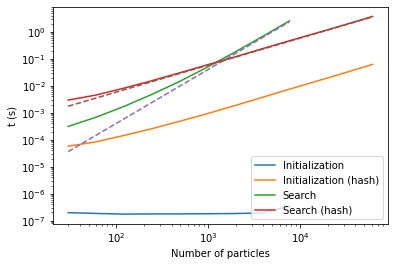

In [16]:
plt.plot(brute_bench['n_particles'], brute_bench['init_time'], label="Initialization")
plt.plot(hash_bench['n_particles'], hash_bench['init_time'], label="Initialization (hash)")

plt.plot(brute_bench['n_particles'], brute_bench['search_time'], label="Search")
plt.plot(hash_bench['n_particles'], hash_bench['search_time'], label="Search (hash)")

plt.plot(brute_bench['n_particles'], 4e-8*brute_bench['n_particles']**2, linestyle="--")
plt.plot(hash_bench['n_particles'], 5.8e-5*hash_bench['n_particles']**1, linestyle="--")
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Number of particles')
plt.ylabel('t (s)')
plt.show()